In [ ]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir ="/content/drive/MyDrive/Flower_Dataset/train"

In [ ]:
print(os.listdir("/content/drive/MyDrive/Flower_Dataset/train"))

['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2746 files belonging to 5 classes.
Using 549 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


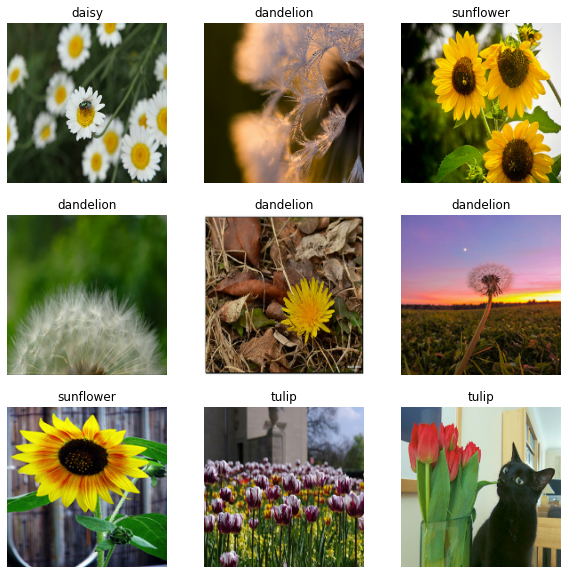

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9934641


In [ ]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
69/69 [==============================] - 109s 2s/step - loss: 1.3468 - accuracy: 0.4087 - val_loss: 1.2317 - val_accuracy: 0.4718
Epoch 2/10
69/69 [==============================] - 95s 1s/step - loss: 1.1051 - accuracy: 0.5467 - val_loss: 1.1286 - val_accuracy: 0.5282
Epoch 3/10
69/69 [==============================] - 95s 1s/step - loss: 0.9951 - accuracy: 0.6218 - val_loss: 1.0355 - val_accuracy: 0.6193
Epoch 4/10
69/69 [==============================] - 93s 1s/step - loss: 0.8141 - accuracy: 0.6827 - val_loss: 0.9415 - val_accuracy: 0.6393
Epoch 5/10
69/69 [==============================] - 92s 1s/step - loss: 0.6987 - accuracy: 0.7342 - val_loss: 0.9010 - val_accuracy: 0.6466
Epoch 6/10
69/69 [==============================] - 90s 1s/step - loss: 0.5739 - accuracy: 0.7833 - val_loss: 0.9728 - val_accuracy: 0.6448
Epoch 7/10
69/69 [==============================] - 94s 1s/step - loss: 0.4324 - accuracy: 0.8471 - val_loss: 1.1133 - val_accuracy: 0.6357
Epoch 8/10
69/69 [=

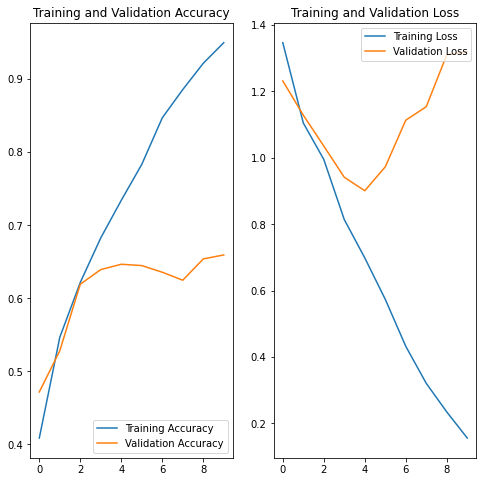

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

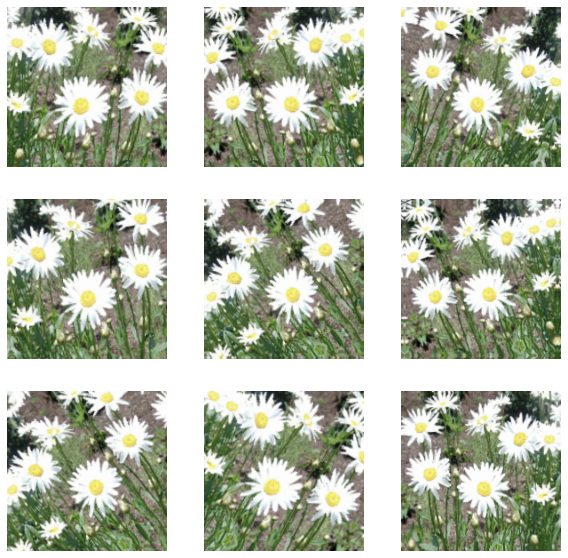

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20


69/69 [==============================] - 100s 1s/step - loss: 1.3882 - accuracy: 0.4069 - val_loss: 1.1855 - val_accuracy: 0.4791
Epoch 2/20
69/69 [==============================] - 100s 1s/step - loss: 1.0630 - accuracy: 0.5694 - val_loss: 1.1025 - val_accuracy: 0.5719
Epoch 3/20
69/69 [==============================] - 99s 1s/step - loss: 0.9269 - accuracy: 0.6359 - val_loss: 0.9570 - val_accuracy: 0.6321
Epoch 4/20
69/69 [==============================] - 94s 1s/step - loss: 0.8534 - accuracy: 0.6627 - val_loss: 0.9315 - val_accuracy: 0.6448
Epoch 5/20
69/69 [==============================] - 99s 1s/step - loss: 0.8079 - accuracy: 0.6891 - val_loss: 0.9560 - val_accuracy: 0.6375
Epoch 6/20
69/69 [==============================] - 105s 2s/step - loss: 0.7729 - accuracy: 0.7055 - val_loss: 0.9109 - val_accuracy: 0.6648
Epoch 7/20
69/69 [==============================] - 100s 1s/step - loss: 0.6884 - accuracy: 0.7365 - val_loss: 0.8685 - val_accuracy: 0.6740
Epoch 8/20
69/69 [=========

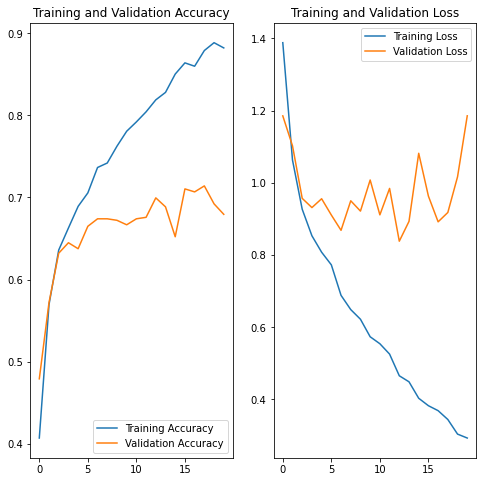

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predict_path = "/content/drive/MyDrive/Flower_Dataset/test/Image_2.jpg"

img = tf.keras.utils.load_img(
    predict_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to sunflower with a 100.00 percent confidence.


In [ ]:
import h5py
model.save('/content/drive/MyDrive/Flower_Dataset/model/model.h5')